In [1]:
%pylab inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import numpy.random as rng
import pandas.io.data as web
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_prices(symbol):
    start, end = '2007-05-02', '2016-04-11'
    data = web.DataReader(symbol, 'yahoo', start, end)
    data=pd.DataFrame(data)
    prices=data['Adj Close']
    prices=prices.astype(float)
    return prices

def get_returns(prices):
        return ((prices-prices.shift(-1))/prices)[:-1]
    
def get_data(list):
    l = []
    for symbol in list:
        rets = get_returns(get_prices(symbol))
        l.append(rets)
    return np.array(l).T

def sort_data(rets):
    ins = []
    outs = []
    for i in range(len(rets)-100):
        ins.append(rets[i:i+100].tolist())
        outs.append(rets[i+100])
    return np.array(ins), np.array(outs)
        


In [3]:
symbol_list = ['C', 'GS']
rets = get_data(symbol_list)
ins, outs = sort_data(rets)
ins = ins.transpose([0,2,1]).reshape([-1, len(symbol_list) * 100])
div = int(.8 * ins.shape[0])
train_ins, train_outs = ins[:div], outs[:div]
test_ins, test_outs = ins[div:], outs[div:]

#normalize inputs
train_ins, test_ins = train_ins/np.std(ins), test_ins/np.std(ins)

In [4]:
sess = tf.InteractiveSession()

In [28]:
positions = tf.constant([-1,0,1]) #long, neutral or short
num_positions = 3
num_symbols = len(symbol_list)
num_samples = 20

x = tf.placeholder(tf.float32, [None, num_symbols * 100])
y_ = tf.placeholder(tf.float32, [None,  num_symbols])

W = tf.Variable(tf.random_normal([num_symbols * 100, num_positions * num_symbols]))
b = tf.Variable(tf.random_normal([num_positions * num_symbols]))

y = tf.matmul(x, W) + b 

# loop through symbol, taking the columns for each symbol's bucket together
pos = {}
sample_n = {}
sample_mask = {}
symbol_returns = {}
relevant_target_column = {}
for i in range(num_symbols):
    # isolate the buckets relevant to the symbol and get a softmax as well
    symbol_probs = y[:,i*num_positions:(i+1)*num_positions]
    symbol_probs_softmax = tf.nn.softmax(symbol_probs) # softmax[i, j] = exp(logits[i, j]) / sum(exp(logits[i]))
    # sample probability to chose our policy's action
    sample = tf.multinomial(tf.log(symbol_probs_softmax), num_samples)
    # isolate the probability of the selected policy (for use in calculating gradient)
    for sample_iter in range(num_samples):
        sample_n[i*num_samples + sample_iter] = sample[:,sample_iter]
        pos[i*num_samples + sample_iter] = tf.reshape(sample_n[i*num_samples + sample_iter], [-1]) - 1
        symbol_returns[i*num_samples + sample_iter] = tf.mul(
                                                            tf.cast(pos[i*num_samples + sample_iter], float32), 
                                                             y_[:,i])
        
        sample_mask[i*num_samples + sample_iter] = tf.cast(tf.reshape(tf.one_hot(sample_n[i*num_samples + sample_iter], 3), [-1,3]), float32)
        relevant_target_column[i*num_samples + sample_iter] = tf.reduce_sum(
                                                    symbol_probs_softmax * sample_mask[i*num_samples + sample_iter],1)
    


daily_returns_by_symbol_ = tf.concat(1, [tf.reshape(t, [-1,1]) for t in symbol_returns.values()])
daily_returns_by_symbol = tf.transpose(tf.reshape(daily_returns_by_symbol_, [-1,2,num_samples]), [0,2,1]) #[?,5,2]
daily_returns = tf.reduce_mean(daily_returns_by_symbol, 2) # [?,5]

total_return = tf.reduce_prod(daily_returns+1, 0)
z = tf.ones_like(total_return) * -1
total_return = tf.add(total_return, z)


ann_vol = tf.mul(
    tf.sqrt(tf.reduce_mean(tf.pow((daily_returns - tf.reduce_mean(daily_returns, 0)),2),0)) ,
    np.sqrt(252)
    )
sharpe = tf.div(total_return, ann_vol)
#Maybe metric slicing later
#segment_ids = tf.ones_like(daily_returns[:,0])
#partial_prod = tf.segment_prod(daily_returns+1, segment_ids)


training_target_cols = tf.concat(1, [tf.reshape(t, [-1,1]) for t in relevant_target_column.values()])
ones = tf.ones_like(training_target_cols)
gradient_ = tf.nn.sigmoid_cross_entropy_with_logits(training_target_cols, ones)
gradient = tf.transpose(tf.reshape(gradient_, [-1,2,num_samples]), [0,2,1]) #[?,5,2]

#cost = tf.mul(gradient , daily_returns_by_symbol_reshaped)
#cost = tf.mul(gradient , tf.expand_dims(daily_returns, -1))
#cost = tf.mul(gradient , tf.expand_dims(total_return, -1))
cost = tf.mul(gradient , tf.expand_dims(sharpe, -1))

optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(cost)
costfn = tf.reduce_mean(cost)






In [29]:
# initialize variables to random values
init = tf.initialize_all_variables()
sess.run(init)
# run optimizer on entire training data set many times
train_size = train_ins.shape[0]
for epoch in range(2000):
    start = rng.randint(train_size-50)
    batch_size = rng.randint(2,75)
    end = min(train_size, start+batch_size)
    
    sess.run(optimizer, feed_dict={x: train_ins[start:end], y_: train_outs[start:end]})#.reshape(1,-1).T})
    # every 1000 iterations record progress
    if (epoch+1)%100== 0:
        t,s, c = sess.run([ total_return, sharpe, costfn], feed_dict={x: train_ins, y_: train_outs})#.reshape(1,-1).T})
        t = np.mean(t)
        s = np.mean(s)
        print("Epoch:", '%04d' % (epoch+1), "cost=",c, "total return=", "{:.9f}".format(t), 
             "sharpe=", "{:.9f}".format(s))
        #print(t)

Epoch: 0100 cost= 1.00206 total return= 1.030627847 sharpe= 2.974764585
Epoch: 0200 cost= 1.71568 total return= 1.791099191 sharpe= 5.127302170
Epoch: 0300 cost= 1.18157 total return= 1.299349308 sharpe= 3.562587738
Epoch: 0400 cost= 4.58113 total return= 4.952174664 sharpe= 13.827474594
Epoch: 0500 cost= 3.75033 total return= 3.790396929 sharpe= 11.338828087
Epoch: 0600 cost= 3.70331 total return= 3.667084455 sharpe= 11.313572884
Epoch: 0700 cost= 7.53489 total return= 7.399894714 sharpe= 23.092885971
Epoch: 0800 cost= 9.49968 total return= 9.457632065 sharpe= 29.160879135
Epoch: 0900 cost= 6.64928 total return= 6.925337791 sharpe= 20.423311234
Epoch: 1000 cost= 7.90497 total return= 7.837764740 sharpe= 24.406297684
Epoch: 1100 cost= 10.1464 total return= 10.020785332 sharpe= 31.260416031
Epoch: 1200 cost= 12.1423 total return= 12.170903206 sharpe= 37.626712799
Epoch: 1300 cost= 14.3474 total return= 14.200810432 sharpe= 44.518753052
Epoch: 1400 cost= 12.5811 total return= 13.13403606

In [30]:
# in sample results
#init = tf.initialize_all_variables()
#sess.run(init)
d, t = sess.run([daily_returns, total_return], feed_dict={x: train_ins, y_: train_outs})

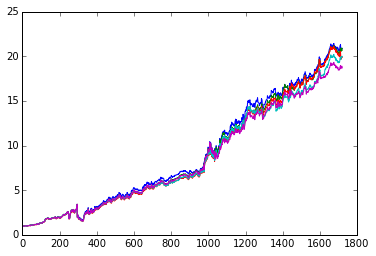

In [31]:
# equity curve
for i in range(5):
    plot(np.cumprod(d[:,[i]]+1))

In [32]:
#out of sample results
d, t = sess.run([daily_returns, total_return], feed_dict={x: test_ins, y_: test_outs})

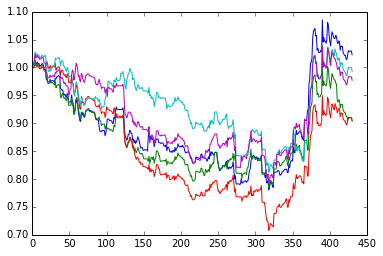

In [33]:
#out of sample results
for i in range(5):
    plot(np.cumprod(d[:,[i]]+1))